<a href="https://colab.research.google.com/github/antproc/Thyroid_nodules_segmentation-/blob/main/Thyroid_nodules_segmentation_ResUNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Display information about the connected GPU in Google Colab

In [1]:
# Execute the 'nvidia-smi' command to obtain GPU information
gpu_info = !nvidia-smi

# Convert the list of output lines into a single string, with each line separated by /n
gpu_info = '\n'.join(gpu_info)

# This is done to check if the command 'nvidia-smi' execution failed to find a GPU
if gpu_info.find('failed') >= 0: # If 'failed' is found, it means the command failed to get GPU information
  print('Not connected to a GPU')
else: # If 'failed' is not found, it means the command successfully obtained GPU information
  print(gpu_info)


Mon Jul 31 11:09:52 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    22W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load data

In [2]:
# Connect to Google Drive and unzip data folders
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/Data_segment

!unzip -jq TDID.zip -d "/content/training_data"
!unzip -jq 2stanf.zip -d "/content/training_data"
!unzip -jq TN3K_train.zip -d "/content/training_data"


Mounted at /content/drive
/content/drive/MyDrive/Data_segment


# Importing necessary libraries and defining functions

In [3]:
# Importing necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader,Dataset
import albumentations
import torchvision
from torchvision import transforms, models
import random
from torchvision import models
from torchsummary import summary
!pip install segmentation-models-pytorch==0.2.1 -q > /dev/null 2>&1
import segmentation_models_pytorch as smp

# Function to convert image to PyTorch tensor format
def convert_to_tensor(x,**kwargs):
    return x.transpose(2,0,1).astype("float32")

# Function for image preprocessing transformations
def func_for_preprocessing(preprocessing_fn=None):
    transform = []
    if preprocessing_fn:
        transform.append(albumentations.Lambda(image=preprocessing_fn))
    transform.append(albumentations.Lambda(image=convert_to_tensor))
    return albumentations.Compose(transform)

# Function for augmentations during training
def trainaugs():
    transform =  [
                albumentations.Resize(height=224,width=224,interpolation=Image.BILINEAR),
                albumentations.RandomBrightnessContrast(brightness_limit=0.35, contrast_limit=0.35),
                albumentations.ShiftScaleRotate(rotate_limit=35, shift_limit=0.35, scale_limit=0.35),
                albumentations.HorizontalFlip(),
            ]
    return albumentations.Compose(transform)

# Function for validation augmentations, only resize
def valaugs():
    transform = [albumentations.Resize(height=224,width=224,interpolation=Image.BILINEAR),]
    return albumentations.Compose(transform)

# Dataset class to load and process images and masks
class GetDataset(Dataset):
    def __init__(self,imagespath,maskspath,augment=None,preprocess=None):
        self.imagespath = imagespath
        self.maskspath = maskspath
        self.augment = augment
        self.preprocess = preprocess

    def __len__(self):
        return len(self.imagespath)

    def __getitem__(self,idx):

        # Read image in RGB format and the corresponding mask in grayscale format
        image = cv2.cvtColor(cv2.imread(self.imagespath[idx]),cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskspath[idx], cv2.IMREAD_GRAYSCALE)

        # If augmentation is enabled, apply transformations to both image and mask
        if self.augment:
            sample = self.augment(image=image, mask=mask)
            image,mask = sample['image'],sample['mask']

        # If preprocessing is enabled, apply transformations to both image and mask
        if self.preprocess:
            sample = self.preprocess(image=image,mask=mask)
            image,mask = sample['image'],sample['mask']

        # Normalize mask values to range [0, 1] and add a channel dimension
        mask = (mask / 255).astype(np.float32)
        mask = np.expand_dims(mask, axis=0)

        return image,mask

# Function for visualizing images
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(18, 7))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        title_words = [word.capitalize() if i == 0 else word for i, word in enumerate(name.split('_'))]
        title = ' '.join(title_words)
        plt.title(title)
        if image.shape[0] == 3:
            image = image.transpose([1, 2, 0])
        plt.imshow(image, cmap='gray')
    plt.show()


# Training of a model

In [4]:
# train folder
trainpath = '/content/training_data/'

# Define the encoder architecture for the U-Net model
encoder = "resnet34"

# As weigths are used pre-trained weights for the encoder
encoder_wts = "imagenet"

# Activation function to be used in the final layer of the model
activation = "sigmoid"

# Create Pytorch the U-Net model with the specified encoder, activation, and weights
model = smp.Unet(encoder_name=encoder,activation=activation,encoder_weights=encoder_wts)

#  Search trainpath fotr masks ipaths and corresponding original images path
masks = [os.path.join(trainpath,i) for i in os.listdir(trainpath) if "mask" in i]
imgs = [i.replace("_mask","") for i in masks]

# Create a DataFrame to hold the image and mask file paths
data_df = pd.DataFrame({"image":imgs,"mask":masks})

# Split the data into training and validation sets in ratio 70/30, can be changed to 80/20 by setting test_size = 0.2
df_train, df_val = train_test_split(data_df,test_size = 0.3)

# Get the preprocessing function for the specified encoder and weights
preprocess_func = smp.encoders.get_preprocessing_fn(encoder,encoder_wts)

# Create a custom dataset for training data, including data augmentation and preprocessing
traindata = GetDataset(imagespath = df_train['image'].tolist(),
                            maskspath = df_train['mask'].tolist(),
                            augment = trainaugs(),
                            preprocess = func_for_preprocessing(preprocess_func)
                            )

# Create a custom dataset for validation data, with preprocessing but no augmentation
validationdata = GetDataset(imagespath = df_val['image'].tolist(),
                            maskspath = df_val['mask'].tolist(),
                            augment = valaugs(),
                            preprocess = func_for_preprocessing(preprocess_func)
                            )

# Specify the batch size for the data loaders
batch_size = 64

# Create data loaders for training and validation data
trainloader = DataLoader(traindata,batch_size = batch_size, shuffle=True, pin_memory=True)
valloader = DataLoader(validationdata,batch_size=batch_size,shuffle=False, pin_memory=True)

# Set the device for training on either CUDA (GPU) if available or CPU otherwise.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

# Define the number of training epochs
epochs = 100

# Define the DiceLoss as the loss function to optimize during training.
loss = smp.utils.losses.DiceLoss()

# Define the IoU metric to evaluate the model's performance.
metrics = [ smp.utils.metrics.IoU(threshold=0.5) ]

# Set up the Adam optimizer with a learning rate of 0.0005, to optimize the model's parameters.
optimizer = torch.optim.Adam([dict(params=model.parameters(), lr=0.0005)])

# Create a learning rate scheduler using CosineAnnealingLR to adjust the learning rate during training.
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs)

# Create a training and validation epoch object
trainepoch = smp.utils.train.TrainEpoch(model,loss=loss,optimizer=optimizer,metrics=metrics, device=device, verbose=True)
validepoch = smp.utils.train.ValidEpoch(model,loss=loss,metrics=metrics, device=device, verbose=True)

# tranining of the model
best_iou = 0
train_logs_list, valid_logs_list = [], []
for i in range(0,epochs):
    print('\nEpoch: {}'.format(i))
    trainlogs = trainepoch.run(trainloader)
    validlogs = validepoch.run(valloader)
    lr_scheduler.step()

    train_logs_list.append(trainlogs)
    valid_logs_list.append(validlogs)
    if best_iou < validlogs['iou_score']:
        best_iou = validlogs['iou_score']
        torch.save(model, '/content/drive/MyDrive/output/best_model_TN3K+TDID+2stanf.pth')


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:17<00:00, 5.13MB/s]


Device: cuda

Epoch: 0
valid: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s, dice_loss - 0.4754, iou_score - 0.4274]

Epoch: 1
valid: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s, dice_loss - 0.3464, iou_score - 0.5319]

Epoch: 2
valid: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s, dice_loss - 0.2782, iou_score - 0.6048]

Epoch: 3
valid: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s, dice_loss - 0.2364, iou_score - 0.6386]

Epoch: 4
valid: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s, dice_loss - 0.2432, iou_score - 0.6268]

Epoch: 5
valid: 100%|██████████| 17/17 [00:05<00:00,  3.10it/s, dice_loss - 0.2107, iou_score - 0.6631]

Epoch: 6
valid: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s, dice_loss - 0.1849, iou_score - 0.6984]

Epoch: 7
valid: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s, dice_loss - 0.1781, iou_score - 0.7048]

Epoch: 8
valid: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s, dice_loss - 0.1765, iou_score - 0.7064]

Epoch: 9
valid: 100%|██████████| 17/17 [0

# Evaluation of a single model

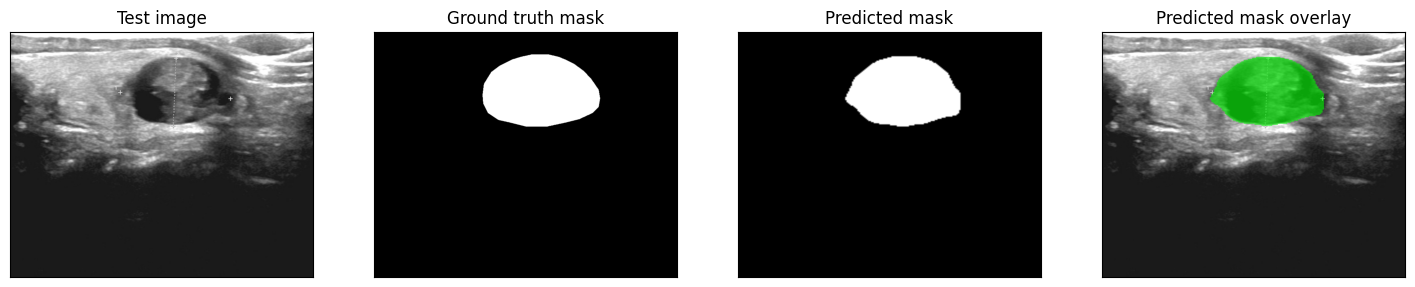

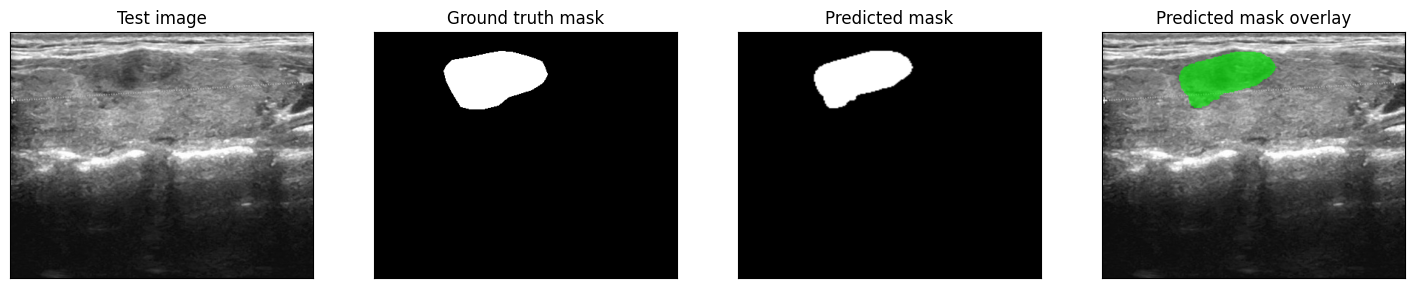

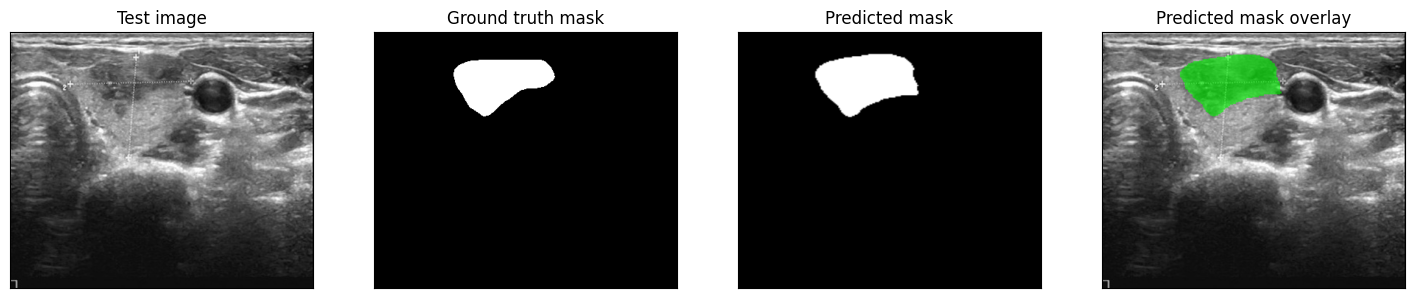

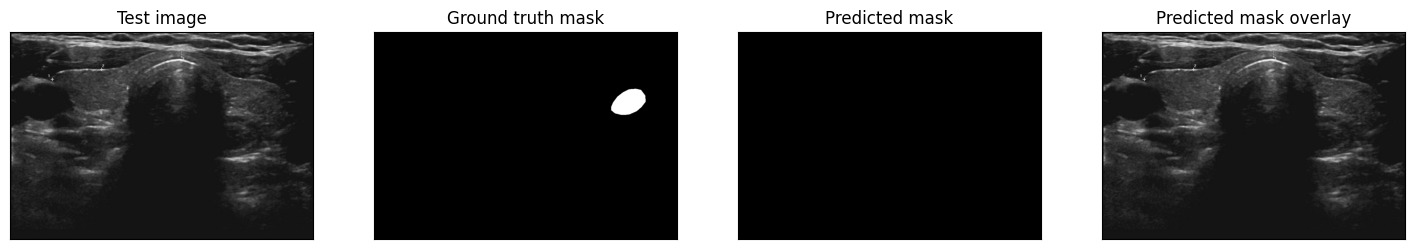

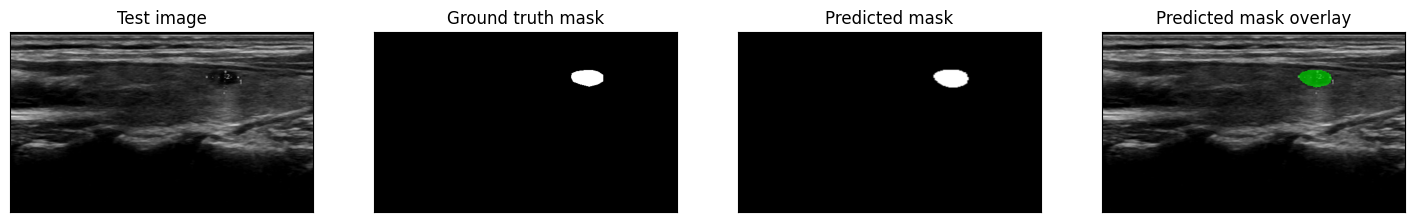

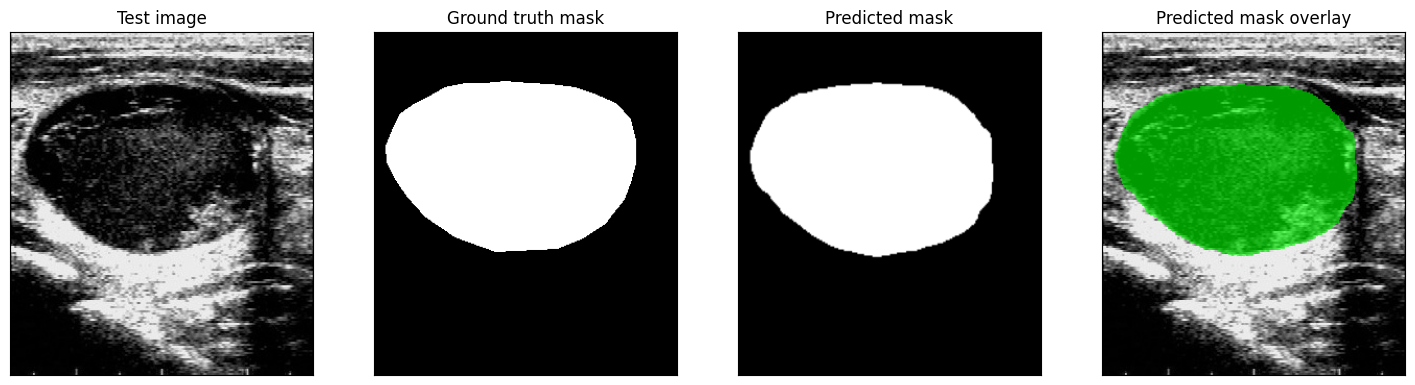

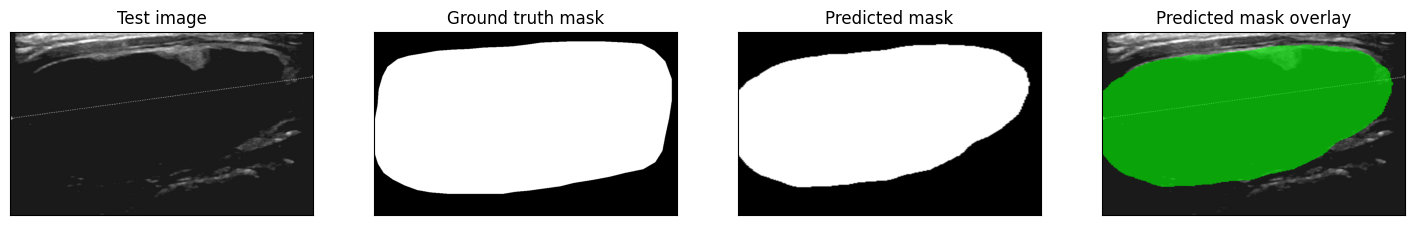

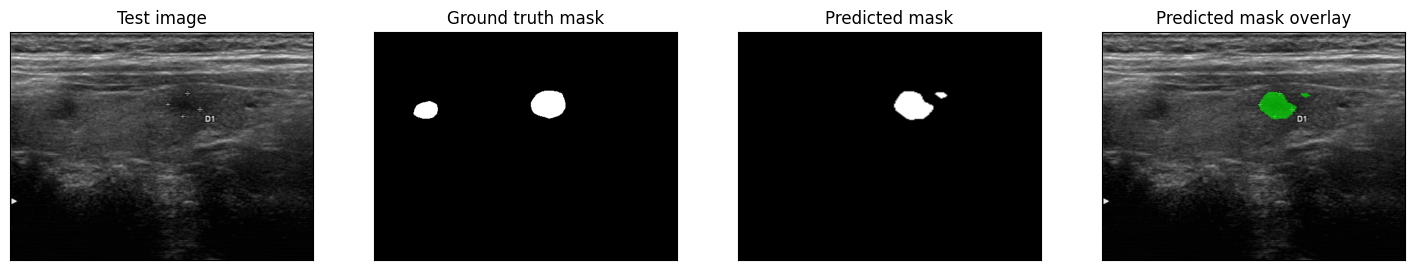

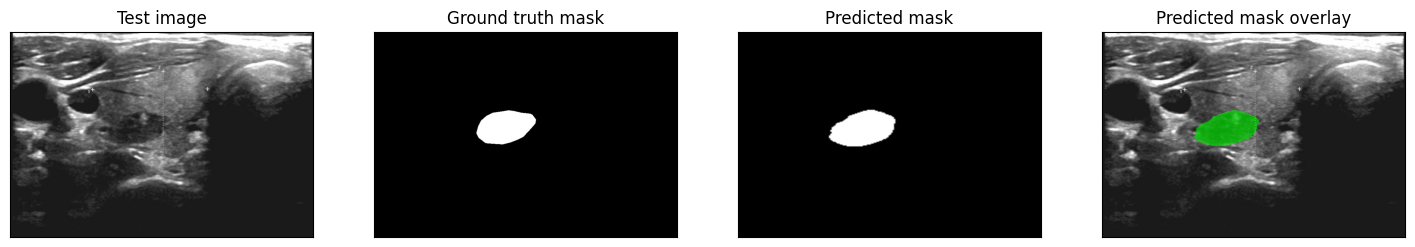

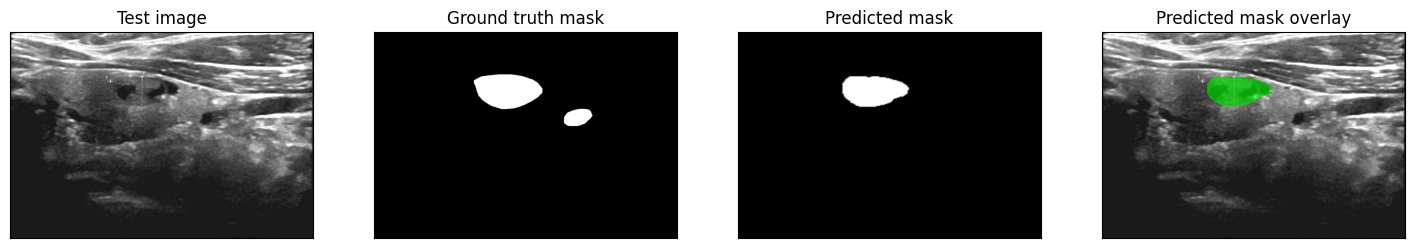

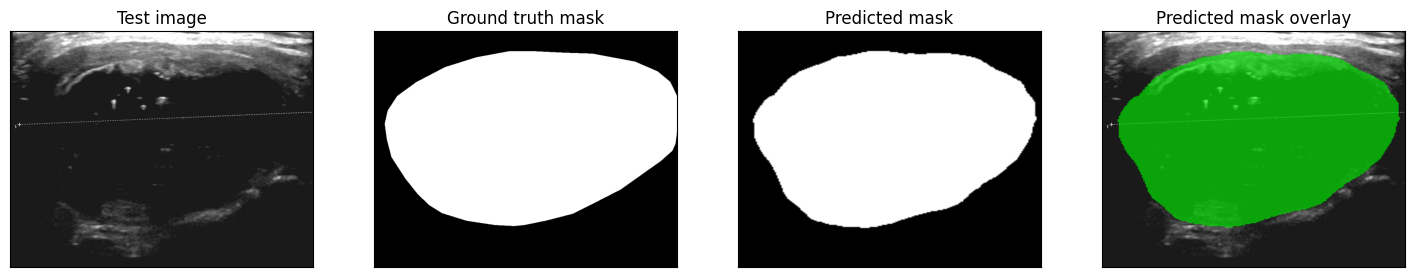

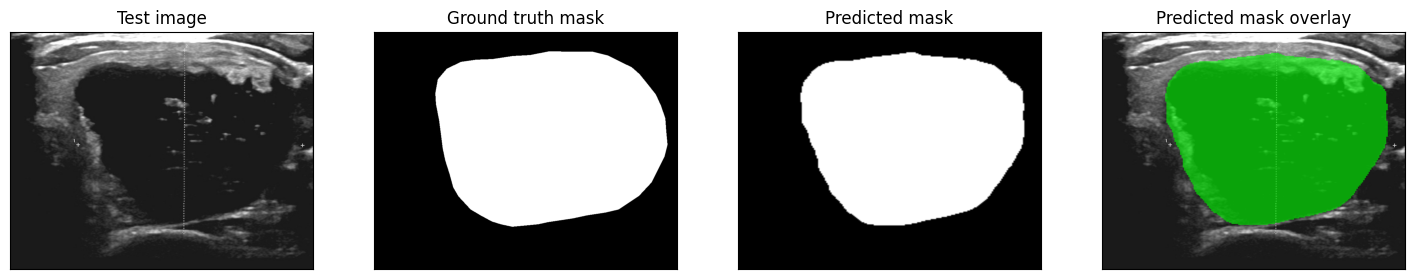

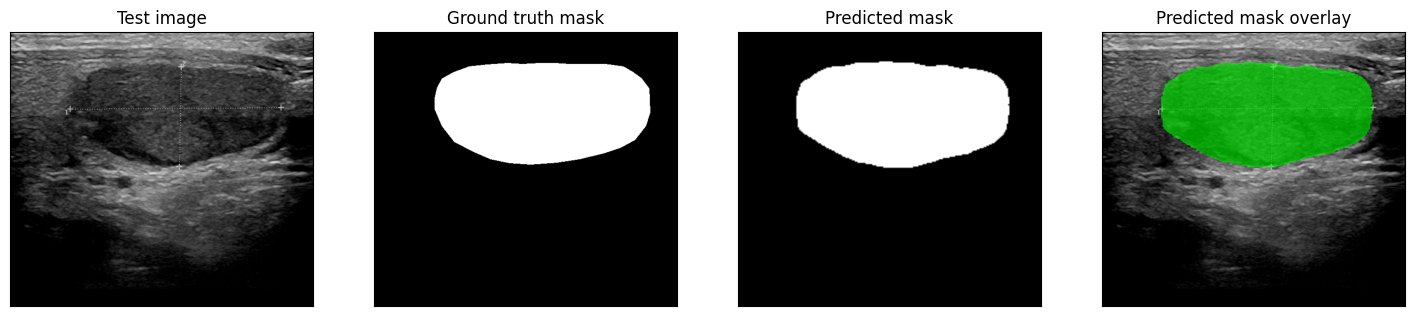

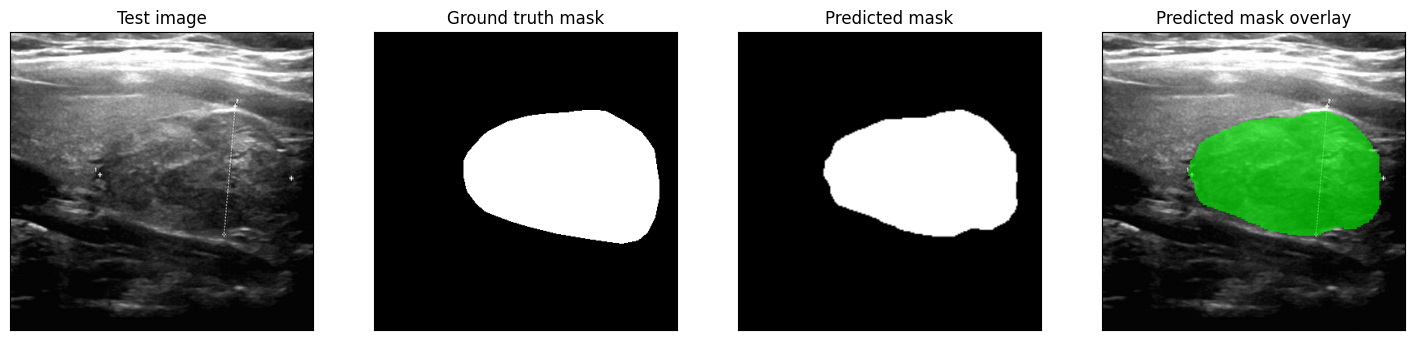

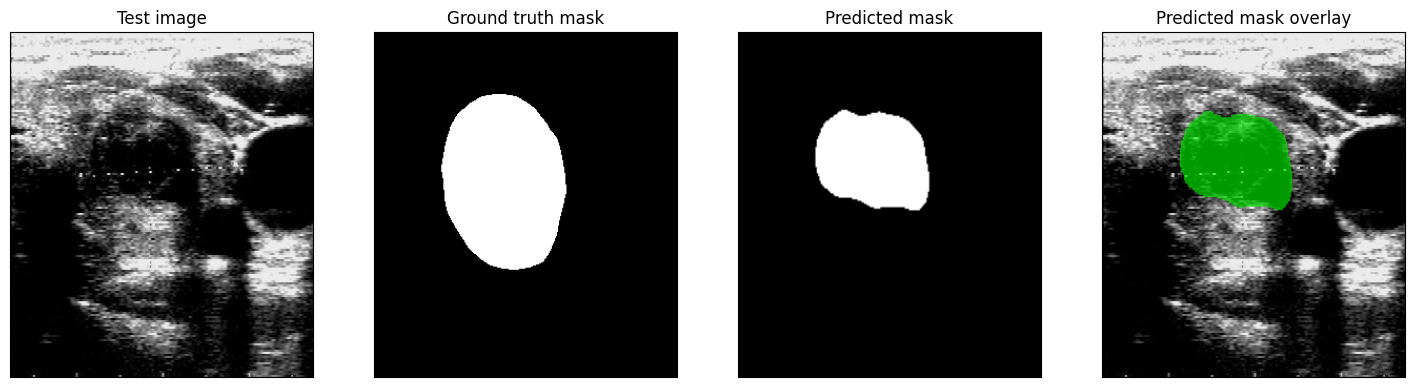

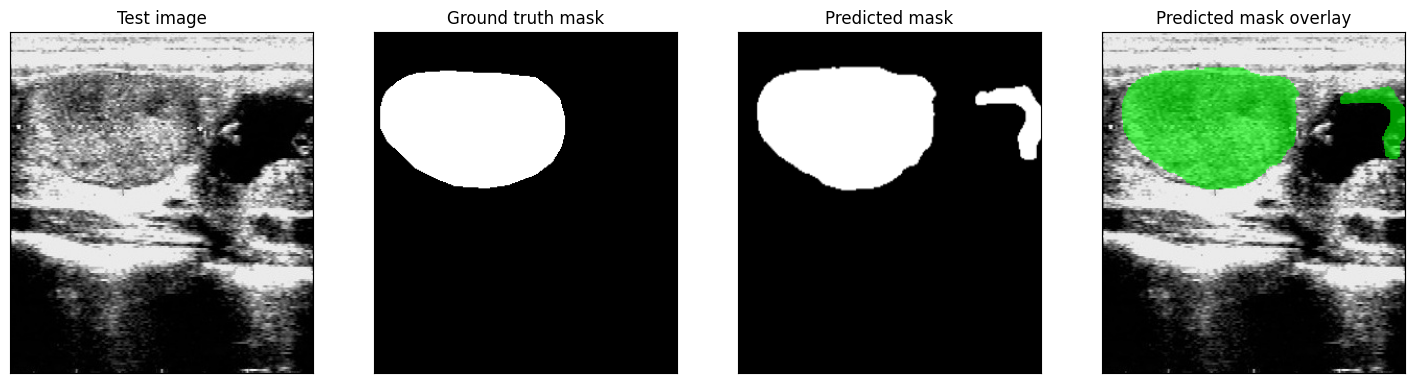

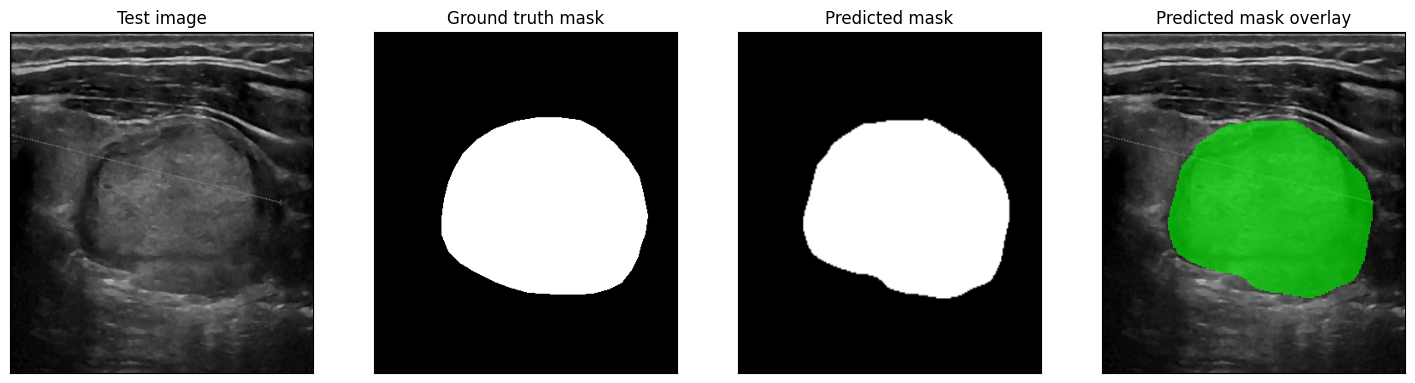

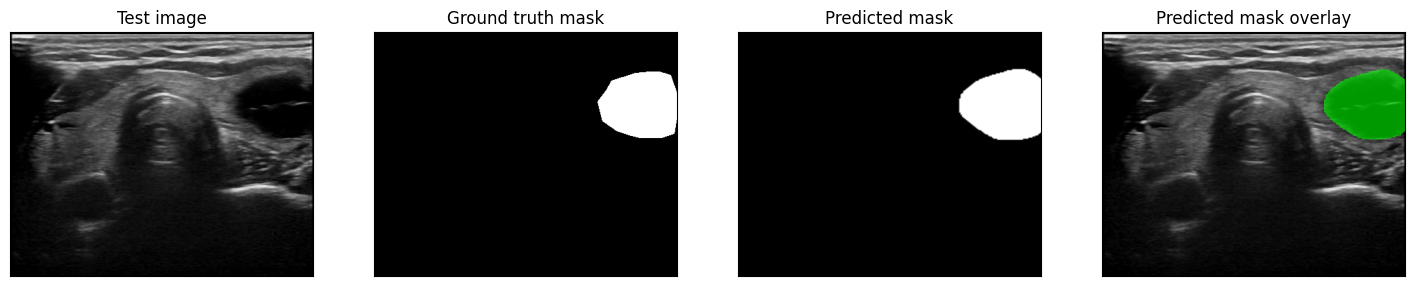

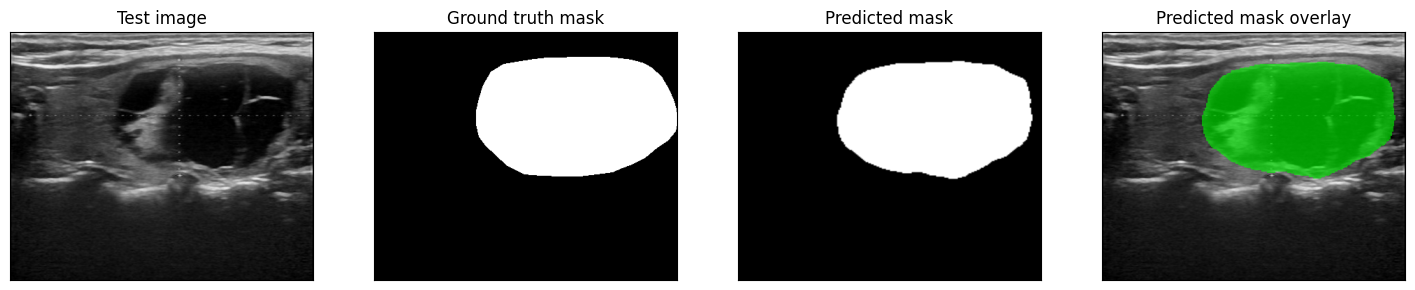

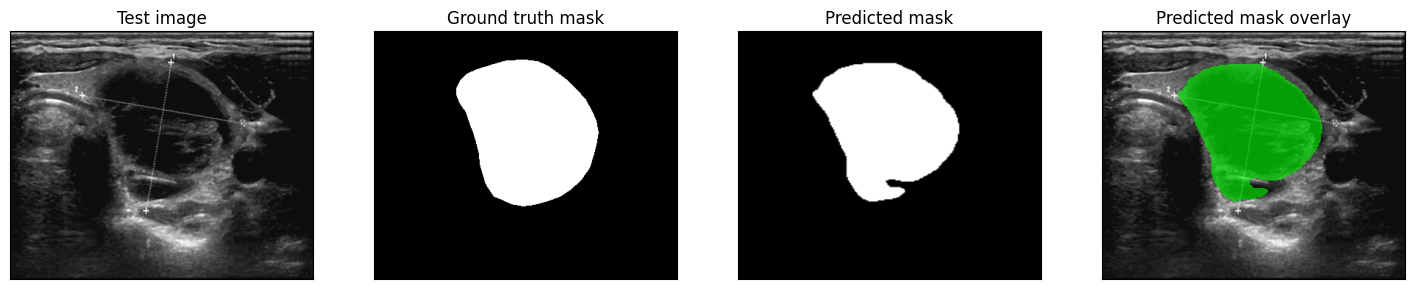

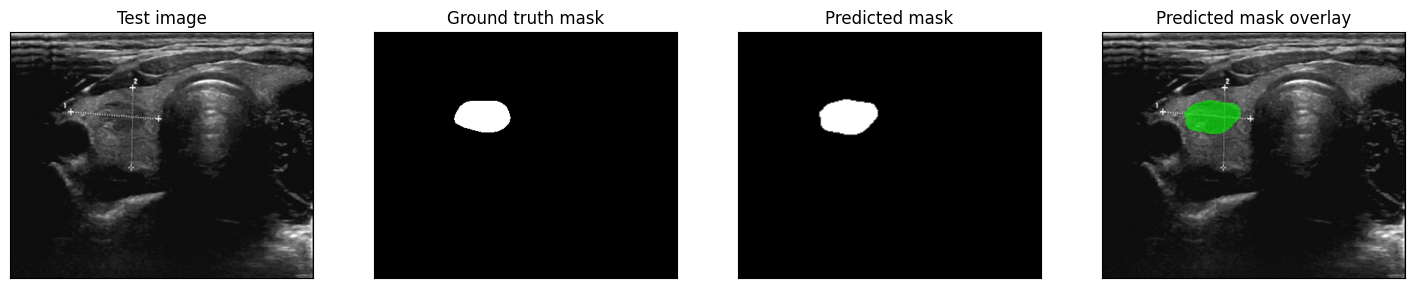

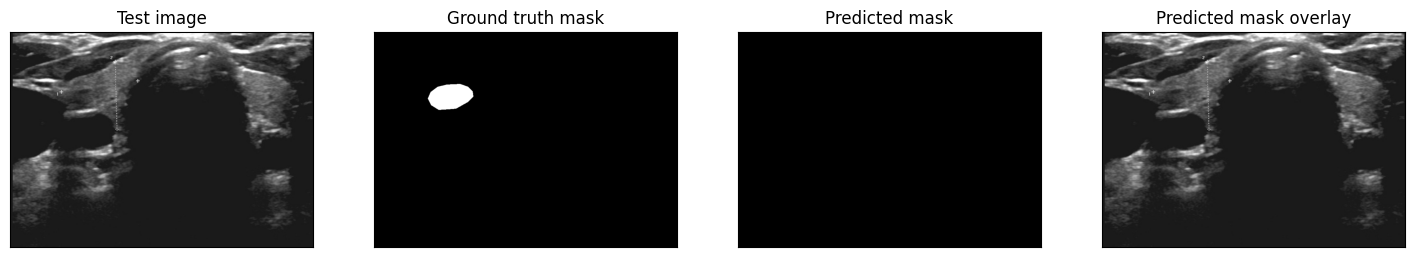

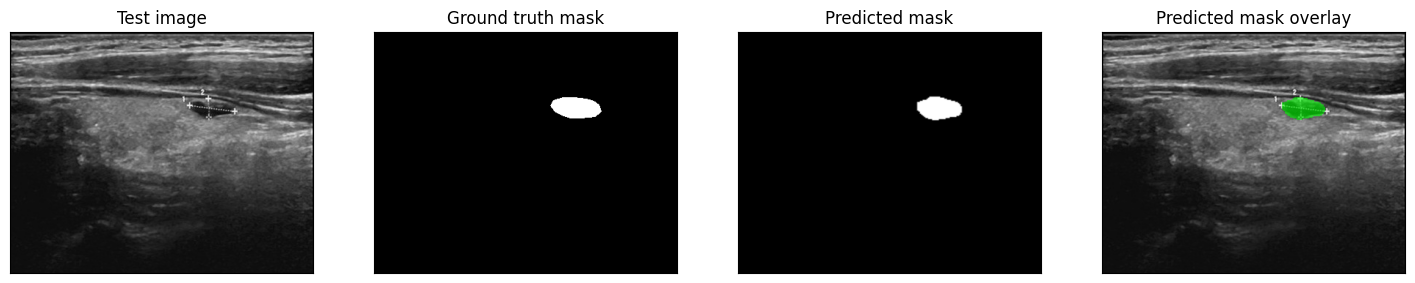

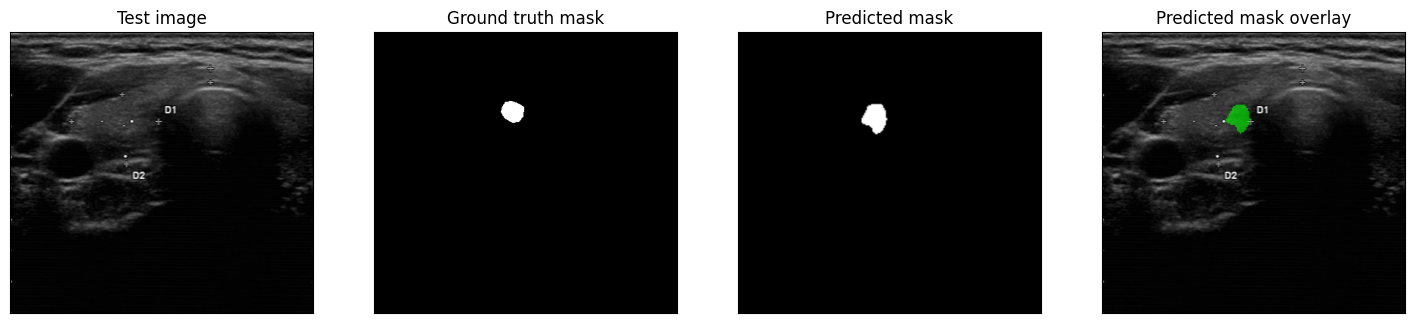

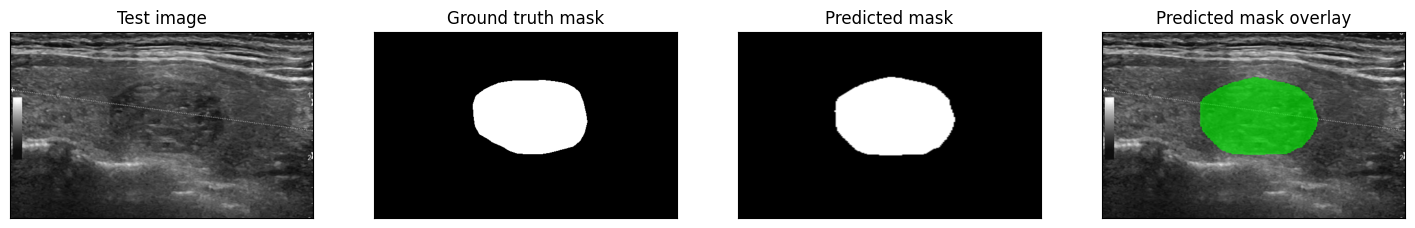

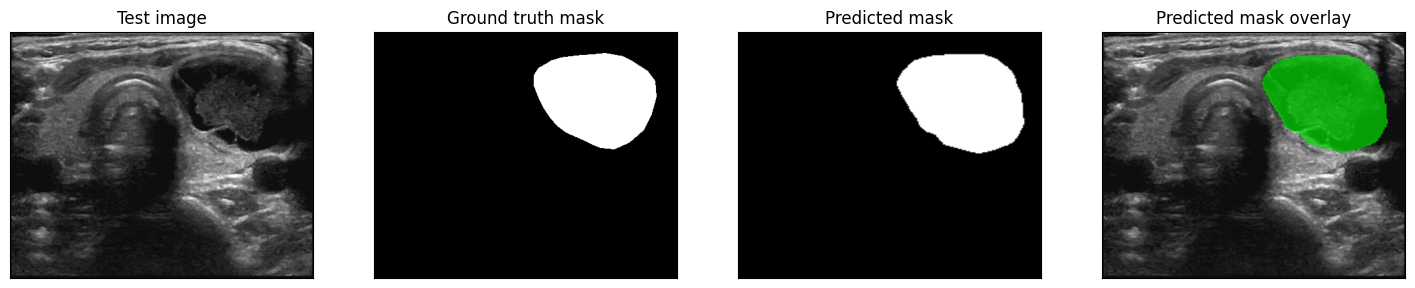

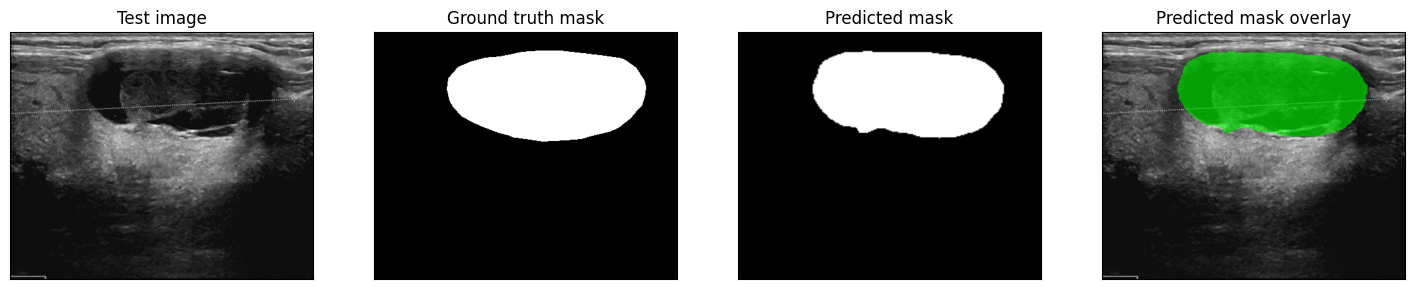

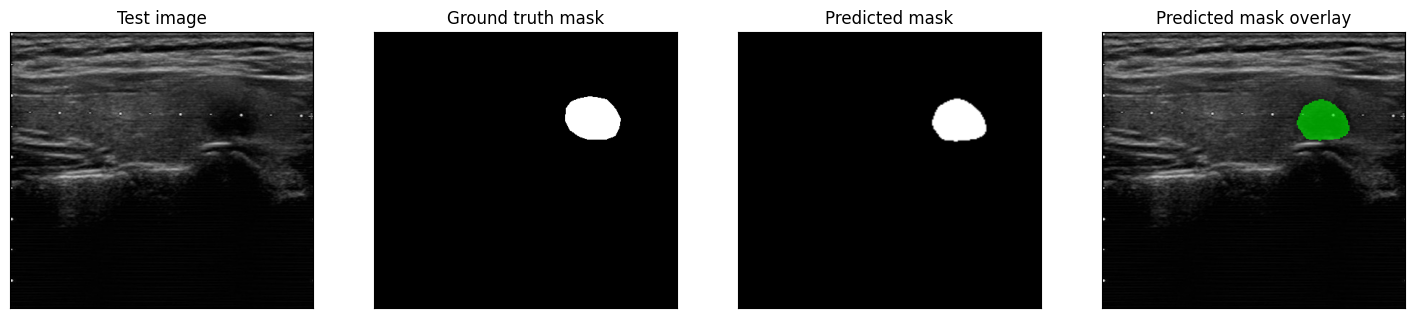

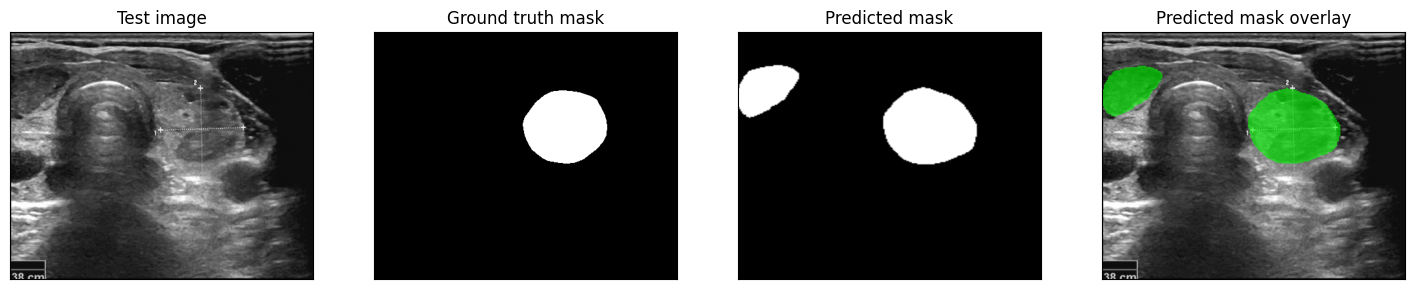

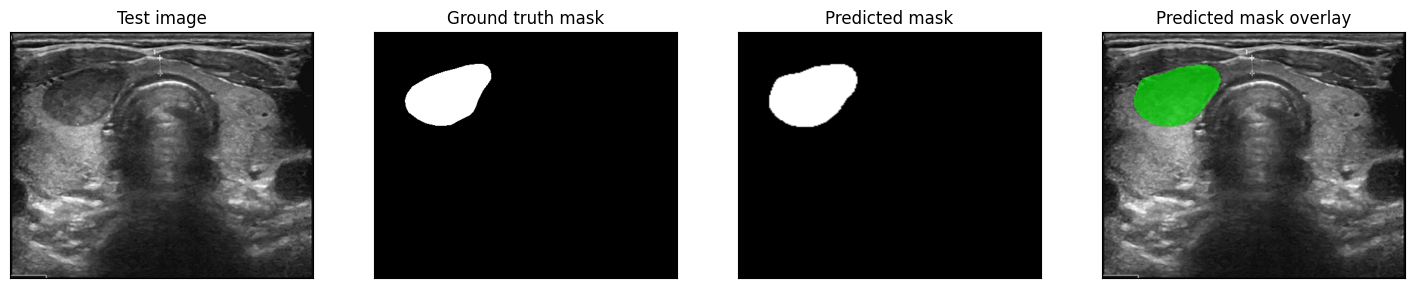

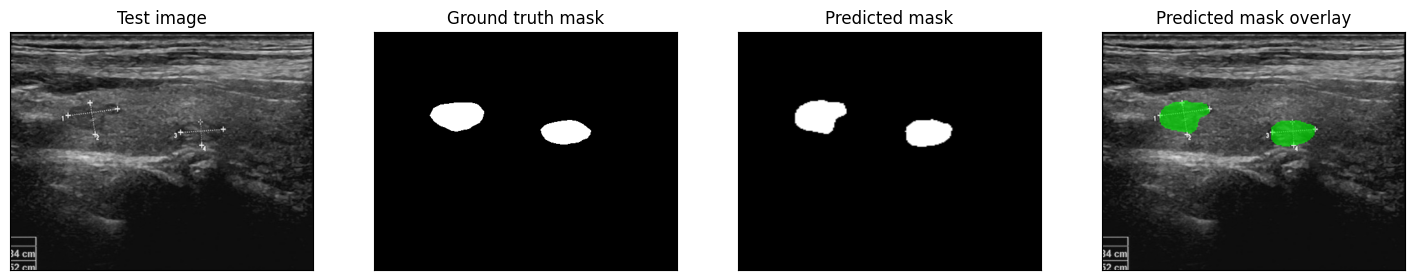

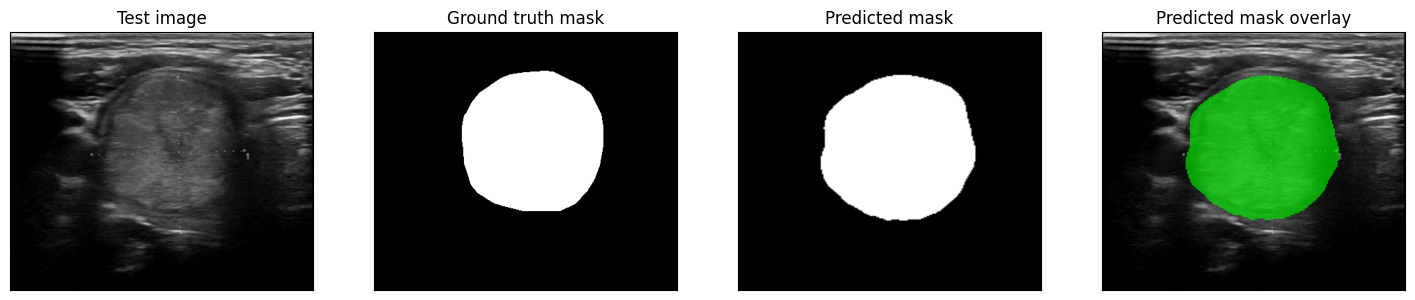

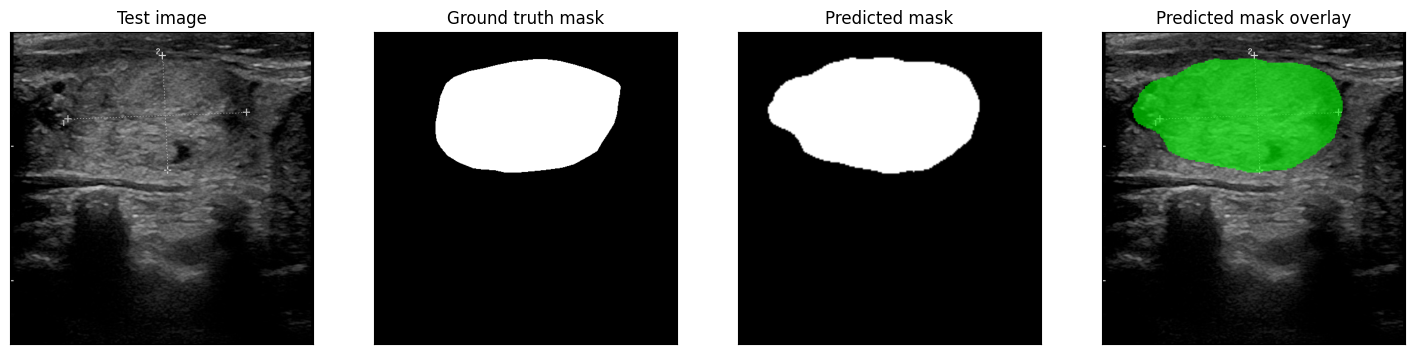

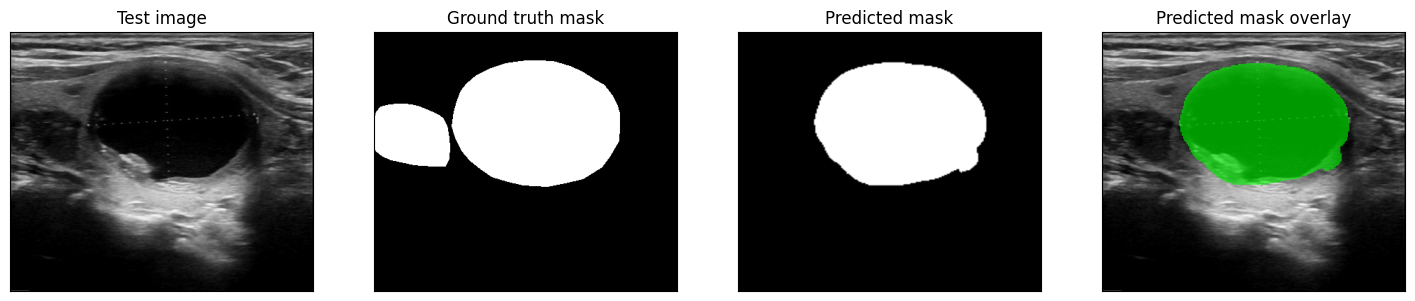

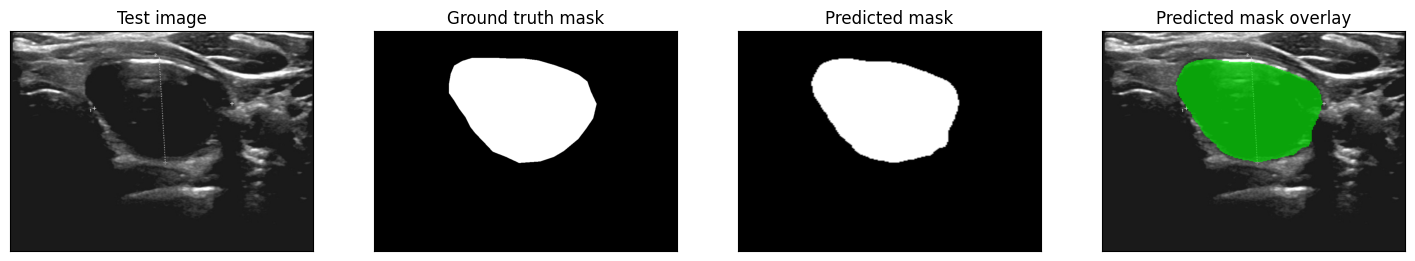

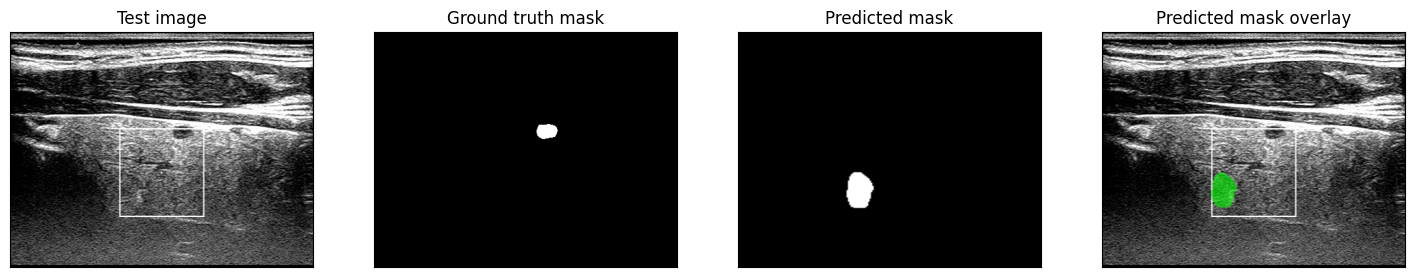

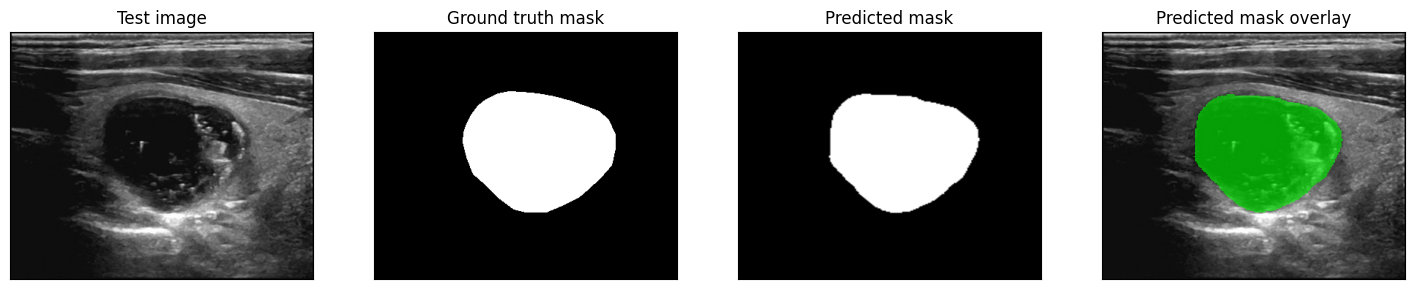

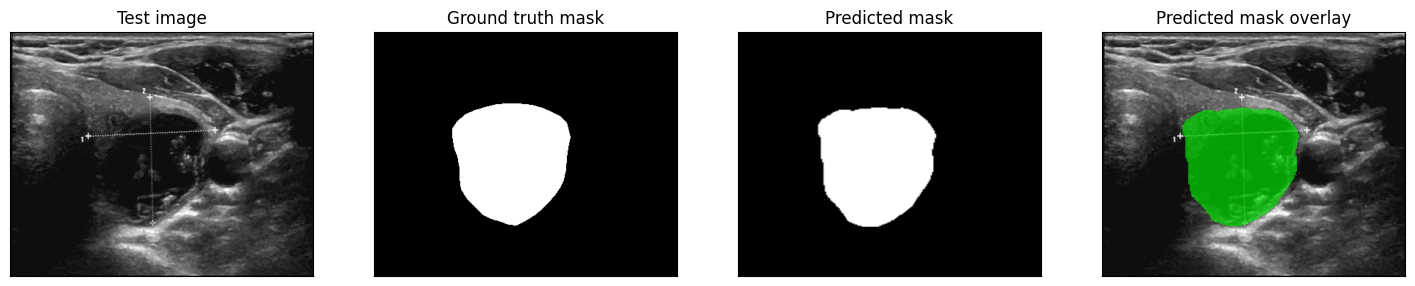

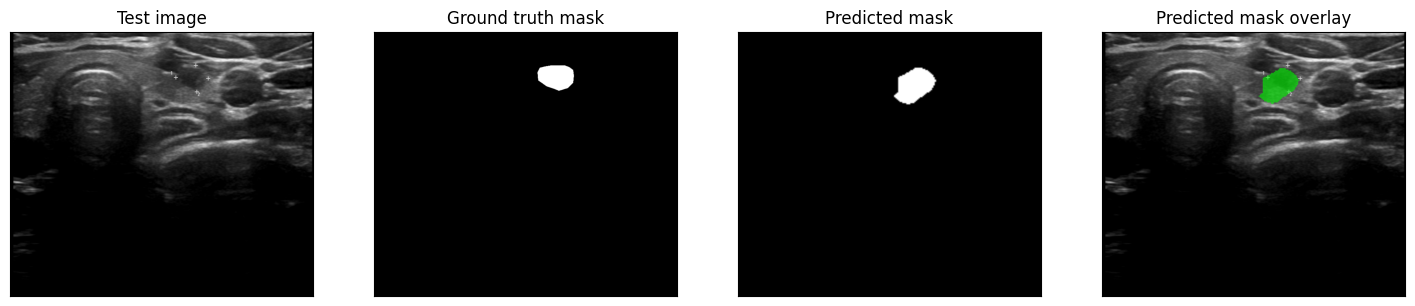

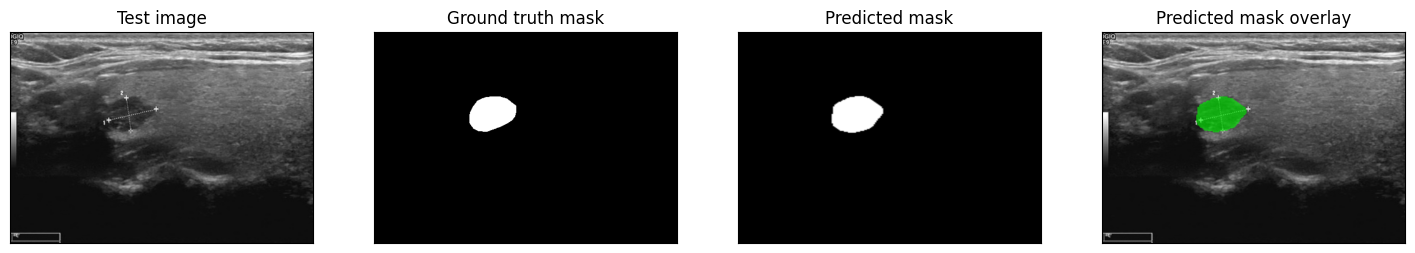

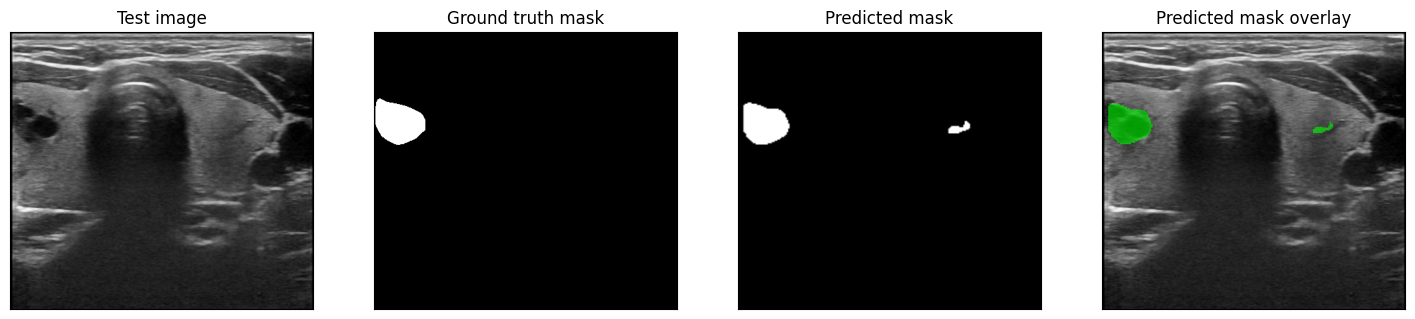

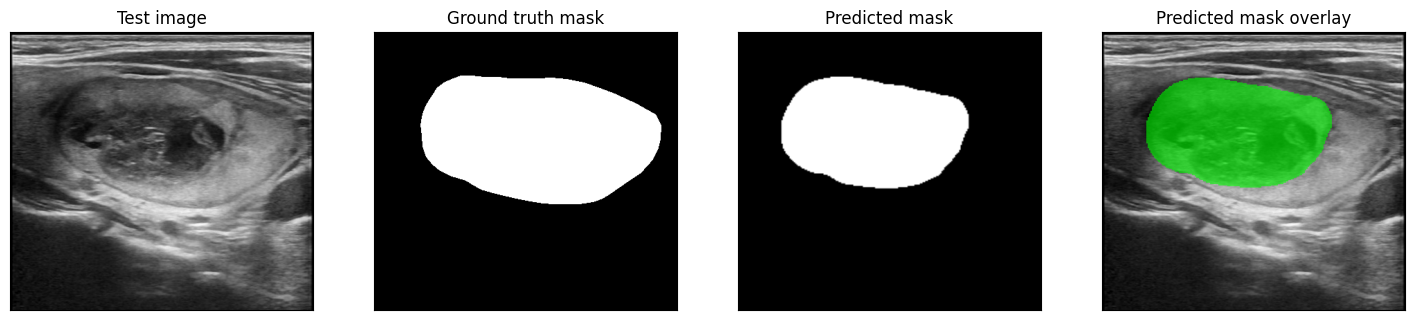

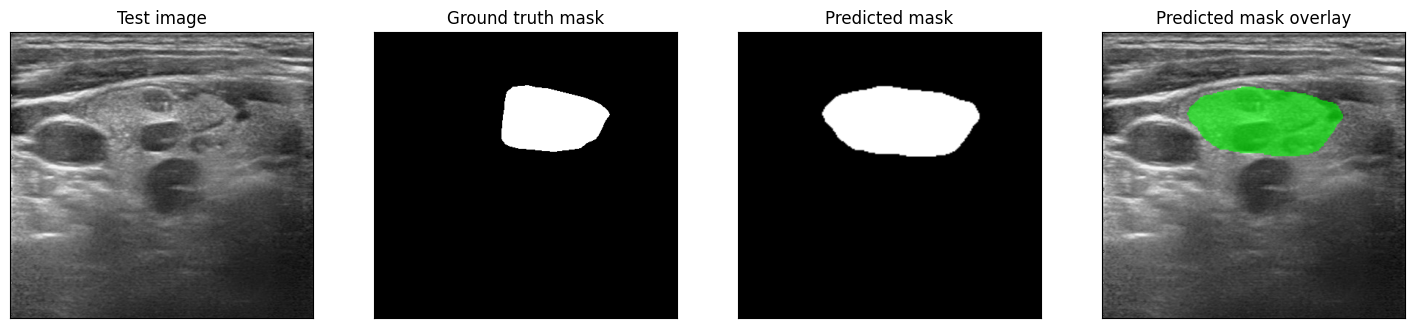

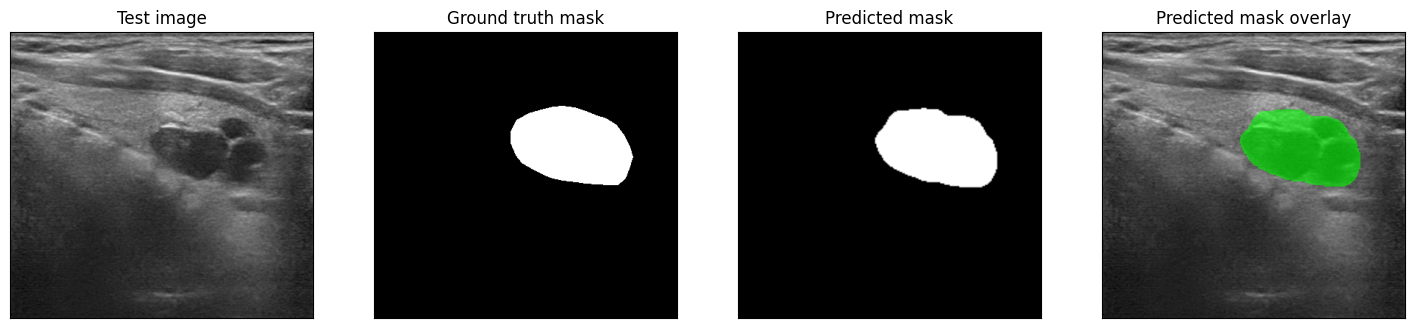

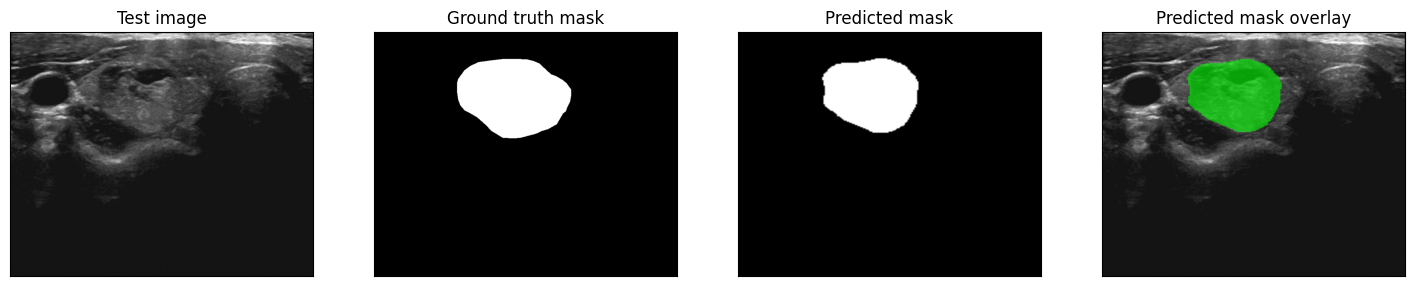

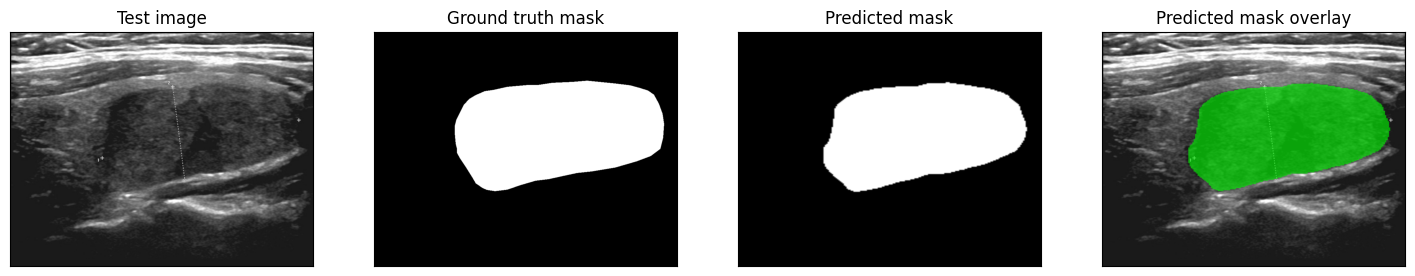

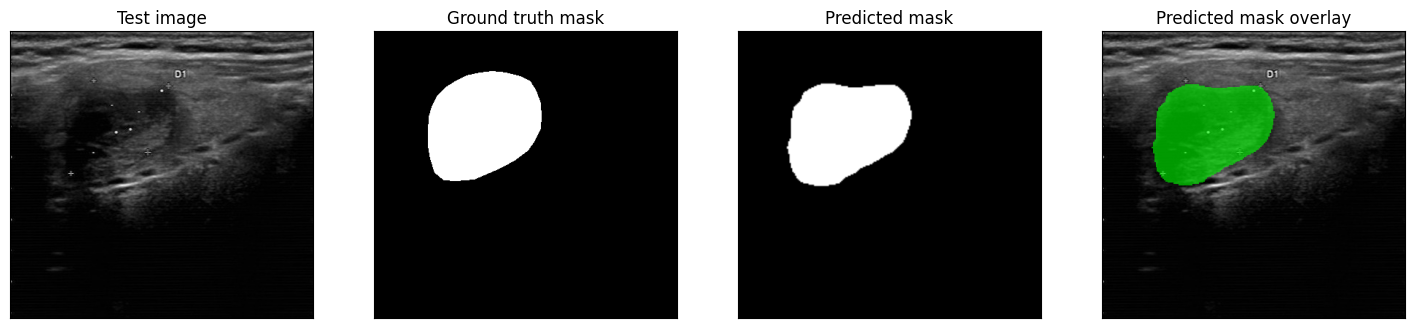

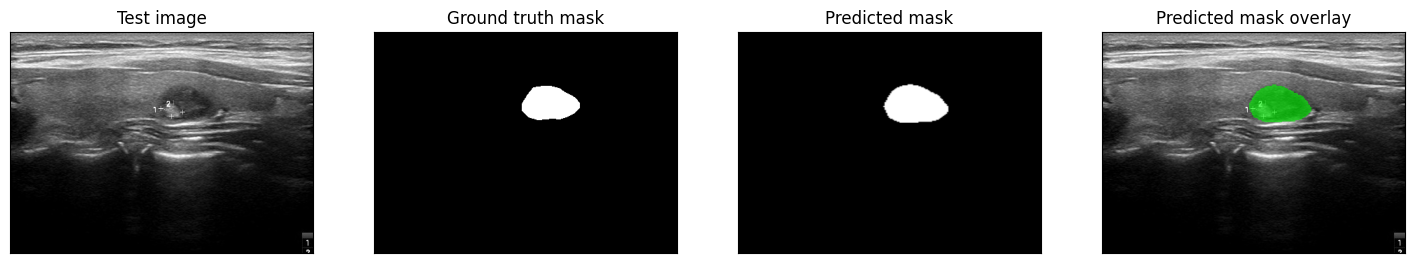

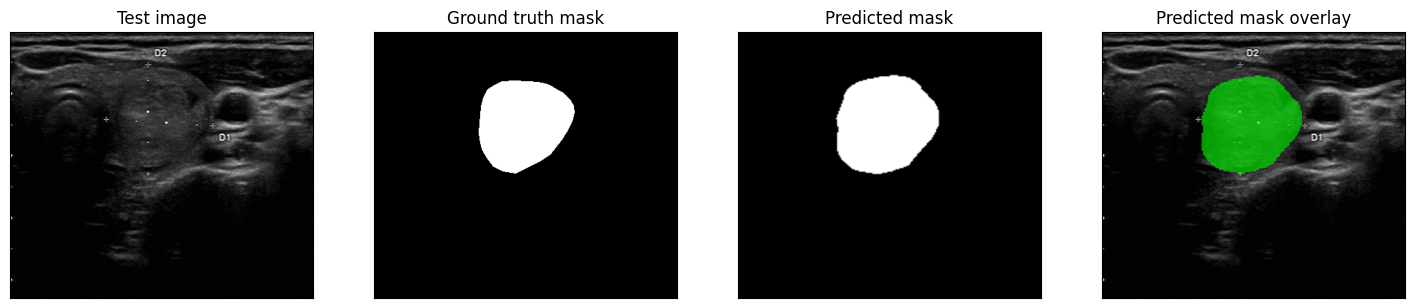

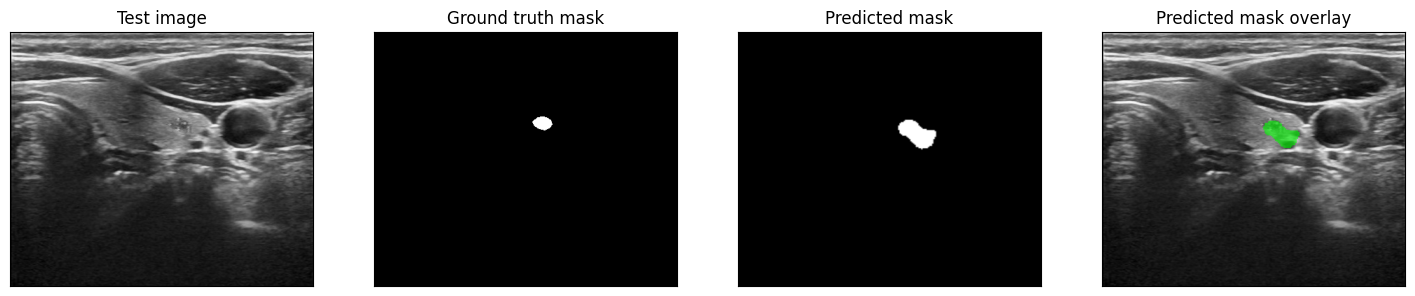

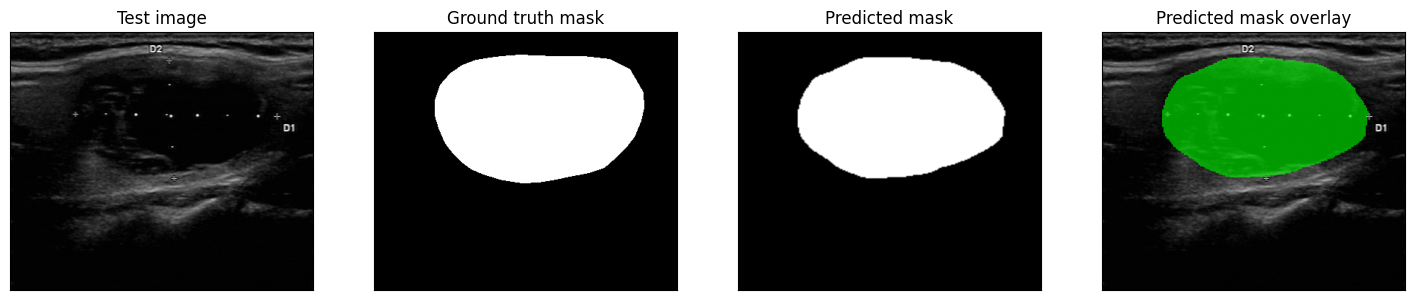

In [13]:
# Set the path to the directory containing the test images and masks.
testpath = '/content/drive/MyDrive/testset_tn3k'

# Load the best model from the specified path
best_model = torch.load('/content/drive/MyDrive/output/best_model_TN3K+TDID+1stanf.pth')

# Define a function to calculate the Dice coefficient, a similarity metric between two binary masks.
def dice(pred, true):
    intersection = np.sum(pred[true == 1]) * 2.0
    dice = intersection / (np.sum(pred) + np.sum(true))
    return dice

# Define a function to calculate the accuracy of the predicted mask compared to the true mask.
def accuracy(pred, true):
    correct = np.sum(pred == true)
    total = true.size
    accuracy = correct / total
    return accuracy

# Define a function to calculate the Intersection over Union (IoU) metric between two binary masks.
def iou(pred, true):
    intersection = np.logical_and(pred, true).sum()
    union = np.logical_or(pred, true).sum()
    iou = intersection / (union + 1e-7)
    return iou

# Define a function to calculate the precision
def precision(pred, true):
    TP = np.logical_and(pred, true).sum()
    FP = np.logical_and(pred, np.logical_not(true)).sum()
    precision = TP / (TP + FP + 1e-7)
    return precision

# Define a function to calculate the recall
def recall(pred, true):
    TP = np.logical_and(pred, true).sum()
    FN = np.logical_and(np.logical_not(pred), true).sum()
    recall = TP / (TP + FN + 1e-7)
    return recall

# Create a list of file paths for mask images and their corresponding original images.
masks = [os.path.join(testpath,i) for i in os.listdir(testpath) if "mask" in i]
imgs = [i.replace("_mask","") for i in masks]

# Create a DataFrame to store the image and mask file paths for test dataset.
test_data_df = pd.DataFrame({"image":imgs,"mask":masks})

# Create a dataset for testing the model
test_dataset = GetDataset(imagespath=test_data_df['image'].tolist(),
                          maskspath=test_data_df['mask'].tolist(),
                          augment=valaugs(),
                          preprocess=func_for_preprocessing(preprocess_func))

# Create a separate dataset for visualization purposes without any preprocessing or augmentation.
test_dataset_vis = GetDataset(imagespath=test_data_df['image'].tolist(),
                              maskspath=test_data_df['mask'].tolist())

# Create three DataFrames: dice_df, accuracy_df, and iou_df, each containing two rows and one column with initial values 0 and 0
dice_df = pd.DataFrame(columns=range(1))
accuracy_df = pd.DataFrame(columns=range(1))
iou_df = pd.DataFrame(columns=range(1))
precision_df = pd.DataFrame(columns=range(1))
recall_df = pd.DataFrame(columns=range(1))

# Loop through the test dataset
i=0
for i in range(len(test_dataset)):

    # Retrieve visualization data for the current image
    image_vis = test_dataset_vis[i][0].astype('uint8')
    mask_vis = test_dataset_vis[i][1].astype('uint8')

    # Retrieve input image and ground truth mask from the test dataset
    image, gt_mask = test_dataset[i]
    gt_mask = gt_mask.squeeze()

    # Convert the input image to a PyTorch tensor and move it to the appropriate device (CPU/GPU)
    x_tensor = torch.from_numpy(image).to(device).unsqueeze(0)

    # Make predictions using the best_model
    pr_mask = best_model.predict(x_tensor)

    # Convert the predicted mask to a NumPy array and round the values to get binary mask (0 or 1)
    pr_mask = pr_mask.squeeze().cpu().numpy().round()

    # Resize predicted masks to the dimensions of the input image
    input_image = cv2.imread(test_data_df.iloc[i]['image'])
    input_image_height, input_image_width, _ = input_image.shape
    pr_mask = cv2.resize(pr_mask, (input_image_width, input_image_height))

    # Squeeze the mask_vis to remove any single-dimensional entries
    mask_vis = mask_vis.squeeze()

    # calculate metrics (Dice score, accuracy, IoU, precision, recall)
    dice_score = dice(pr_mask, mask_vis)
    dice_df.at[i,0]= dice_score

    accuracy_value = accuracy(pr_mask, mask_vis)
    accuracy_df.at[i,0]= accuracy_value

    iou_value = iou(pr_mask, mask_vis)
    iou_df.at[i,0]= iou_value

    precision_value = precision(pr_mask, mask_vis)
    precision_df.at[i,0]=  precision_value

    recall_value = recall(pr_mask, mask_vis)
    recall_df.at[i,0]= recall_value

    # Overlay predicted mask on the image
    overlay = input_image.copy()
    overlay[np.where(pr_mask == 1)] = [0, 255, 0]  # Green color for the predicted mask
    alpha = 0.6  # Opacity of the overlay
    overlay_image = cv2.addWeighted(overlay, alpha, input_image, 1 - alpha, 0)

    # Visualize the input image, ground truth mask, predicted mask, and overlayed image for the first 50 images
    if i <= 50:
      visualize(

          Test_image=input_image,
          ground_truth_mask=mask_vis,
          predicted_mask=pr_mask,
          predicted_mask_overlay = overlay_image
      )


# Calculation of mean a standard deviation for single model

In [14]:
iou_mean = iou_df.mean(axis=0)
accuracy_mean = accuracy_df.mean(axis=0)
dice_mean = dice_df.mean(axis=0)
precision_mean = precision_df.mean(axis=0)
recall_mean = recall_df.mean(axis=0)
iou_std = iou_df.std(axis=0)
accuracy_std = accuracy_df.std(axis=0)
dice_std = dice_df.std(axis=0)
precision_std = precision_df.std(axis=0)
recall_std = recall_df.std(axis=0)


data = {
    "IOU_mean": iou_mean,
    "IOU_std": iou_std,
    "Accuracy_mean": accuracy_mean,
    "Accuracy_std": accuracy_std,
    "Dice_mean": dice_mean,
    "Dice_std": dice_std,
    "Precision_mean": precision_mean,
    "Precision_std": precision_std,
    "Recall_mean": recall_mean,
    "Recall_std": recall_std
}

results = pd.DataFrame(data)
results

IOU_mean   IOU_std  Accuracy_mean  Accuracy_std  Dice_mean  Dice_std  \
0  0.754839  0.208344       0.972442      0.032061   0.842389  0.188886   

   Precision_mean  Precision_std  Recall_mean  Recall_std  
0        0.827472       0.197817     0.889817    0.192596